### <a id='toc1_1_1_'></a>[City of Baltimore Crime Data](https://data.world/data-society/city-of-baltimore-crime-data)  [&#8593;](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [City of Baltimore Crime Data ](#toc1_1_1_)    
  - [Anomaly detection](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [7]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/qvspv6ym4ukn6irryolom4ijbrmfug?dws=00000', parse_dates=True)

In [8]:
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Total Incidents
0,11/12/2016,02:35:00,3B,300 SAINT PAUL PL,ROBBERY - STREET,O,NaN,111.0,CENTRAL,Downtown,"(39.2924100000, -76.6140800000)",1
1,11/12/2016,02:56:00,3CF,800 S BROADWAY,ROBBERY - COMMERCIAL,I,FIREARM,213.0,SOUTHEASTERN,Fells Point,"(39.2824200000, -76.5928800000)",1
2,11/12/2016,03:00:00,6D,1500 PENTWOOD RD,LARCENY FROM AUTO,O,NaN,413.0,NORTHEASTERN,Stonewood-Pentwood-Winston,"(39.3480500000, -76.5883400000)",1
3,11/12/2016,03:00:00,6D,6600 MILTON LN,LARCENY FROM AUTO,O,NaN,424.0,NORTHEASTERN,Westfield,"(39.3626300000, -76.5516100000)",1
4,11/12/2016,03:00:00,6E,300 W BALTIMORE ST,LARCENY,O,NaN,111.0,CENTRAL,Downtown,"(39.2893800000, -76.6197100000)",1


In [9]:
crime_date_total_incidents = df[["CrimeDate", "Total Incidents"]]

# Set 'CrimeDate' as the index
crime_date_total_incidents.set_index('CrimeDate', inplace=True)

In [10]:
crime_date_total_incidents.head()

,Total Incidents
CrimeDate,
11/12/2016,1
11/12/2016,1
11/12/2016,1
11/12/2016,1
11/12/2016,1


In [11]:
grouped = crime_date_total_incidents.groupby('CrimeDate').sum()

In [12]:
grouped.index = pd.to_datetime(grouped.index, format='%m/%d/%Y')

# THIS PART IS IMPORTANT
grouped = grouped.sort_index()

In [13]:
grouped.head()

,Total Incidents
CrimeDate,
2011-01-01,185
2011-01-02,102
2011-01-03,106
2011-01-04,113
2011-01-05,131


In [14]:
print(grouped.index.min())
print(grouped.index.max())

2011-01-01 00:00:00
2016-11-12 00:00:00


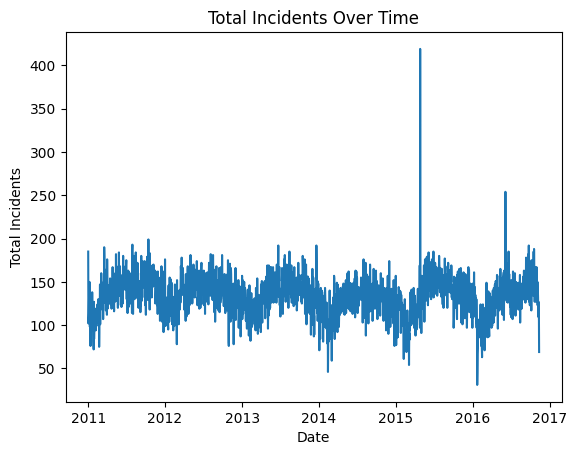

In [15]:
import matplotlib.pyplot as plt

# Assuming 'grouped' is a DataFrame with a datetime index and a 'Total Incidents' column
plt.plot(grouped.index, grouped['Total Incidents'])
plt.title('Total Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Total Incidents')
plt.show()

In [16]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Assuming 'grouped' is a DataFrame with a datetime index and a 'Total Incidents' column
series = TimeSeries.from_dataframe(grouped)

# Split the series into training and validation sets
train_size = int(len(series) * 0.8)
train, val = series[:train_size], series[train_size:]

# Fit the ExponentialSmoothing model to the training data
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.MULTIPLICATIVE)
model.fit(train)

# Generate the forecasts for the validation set
forecast_values = model.predict(n=len(val))

# Print or use the forecast_values as needed
print(forecast_values.pd_series())

CrimeDate
2015-09-11    153.314409
2015-09-12    146.250540
2015-09-13    138.014784
2015-09-14    158.300247
2015-09-15    150.828226
                 ...    
2016-11-08    171.698092
2016-11-09    165.905628
2016-11-10    166.277336
2016-11-11    174.910308
2016-11-12    166.844628
Freq: D, Length: 429, dtype: float64


Backtesting

In [17]:
backtest=model.historical_forecasts(series,
                                    start=.8, # starting at 80% of the time series
                                    forecast_horizon=5) # forecast horizon of the point predictions

<Axes: xlabel='time'>

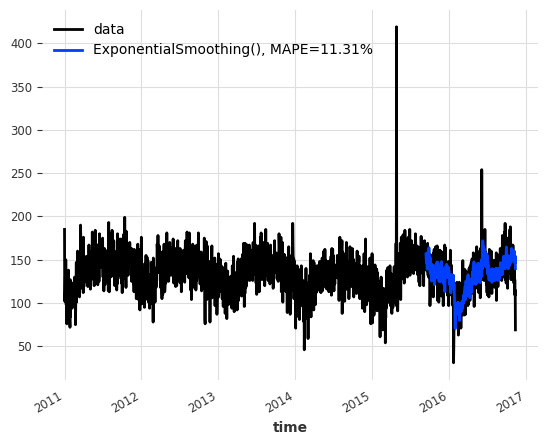

In [18]:
from darts.metrics import mape
series.plot(label="data")
err=mape(backtest,val)
backtest.plot(lw=2, label='ExponentialSmoothing(), MAPE={:.2f}%'.format(err))

In [19]:
# Predict the next 5 days
predictions = model.predict(len(val)+5)
five_day_predictions = predictions.pd_series().tail(5)

# Print or use the forecasted values
print(five_day_predictions)

CrimeDate
2016-11-13    157.442757
2016-11-14    180.576407
2016-11-15    172.045923
2016-11-16    166.241628
2016-11-17    166.613990
Freq: D, dtype: float64


Instead of 5 days, one can choose to predict for a longer time horizon too

<Axes: xlabel='CrimeDate'>

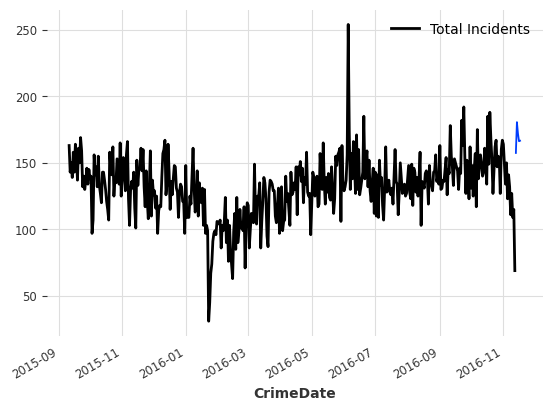

In [20]:
# there seems to be a bit of an increasing trend from this graph
val.plot()
five_day_predictions.plot()

## <a id='toc1_2_'></a>[Anomaly detection](#toc0_)

In [41]:
from prophet import Prophet
import numpy as np
grouped_copy = pd.DataFrame.copy(grouped)
grouped_copy = grouped_copy.reset_index()
# converting to ds and y because of prophet syntax
grouped_copy.columns=['ds','y']
grouped_copy.head()

,ds,y
0,2011-01-01,185
1,2011-01-02,102
2,2011-01-03,106
3,2011-01-04,113
4,2011-01-05,131


In [51]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
   m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
               seasonality_mode = 'additive',
               interval_width = interval_width,
               changepoint_range = changepoint_range)
   # creating a prophet object here
   m = m.fit(dataframe)
   
   # predicting
   forecast = m.predict(dataframe)
   forecast['fact'] = dataframe['y'].reset_index(drop = True)
   return forecast
pred = fit_predict_model(grouped_copy)

15:08:58 - cmdstanpy - INFO - Chain [1] start processing
15:08:58 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact
0,2011-01-01,138.873779,76.335027,172.328060,138.873779,138.873779,-12.108116,-12.108116,-12.108116,-12.108116,-12.108116,-12.108116,0.0,0.0,0.0,126.765663,185
1,2011-01-02,138.873900,79.685576,172.845299,138.873900,138.873900,-12.708352,-12.708352,-12.708352,-12.708352,-12.708352,-12.708352,0.0,0.0,0.0,126.165548,102
2,2011-01-03,138.874021,83.318705,175.796419,138.874021,138.874021,-13.275293,-13.275293,-13.275293,-13.275293,-13.275293,-13.275293,0.0,0.0,0.0,125.598728,106
3,2011-01-04,138.874143,80.479476,172.959472,138.874143,138.874143,-13.805035,-13.805035,-13.805035,-13.805035,-13.805035,-13.805035,0.0,0.0,0.0,125.069108,113
4,2011-01-05,138.874264,77.439471,165.186997,138.874264,138.874264,-14.294516,-14.294516,-14.294516,-14.294516,-14.294516,-14.294516,0.0,0.0,0.0,124.579747,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,2016-11-08,129.738927,87.384267,177.191632,129.738927,129.738927,3.758735,3.758735,3.758735,3.758735,3.758735,3.758735,0.0,0.0,0.0,133.497662,111
2139,2016-11-09,129.730731,85.565264,176.956515,129.730731,129.730731,2.972440,2.972440,2.972440,2.972440,2.972440,2.972440,0.0,0.0,0.0,132.703171,127
2140,2016-11-10,129.722535,87.111941,177.106310,129.722535,129.722535,2.198993,2.198993,2.198993,2.198993,2.198993,2.198993,0.0,0.0,0.0,131.921528,109
2141,2016-11-11,129.714339,82.360180,178.430021,129.714339,129.714339,1.446412,1.446412,1.446412,1.446412,1.446412,1.446412,0.0,0.0,0.0,131.160751,115


In [54]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

    return forecasted
pred = detect_anomalies(pred)

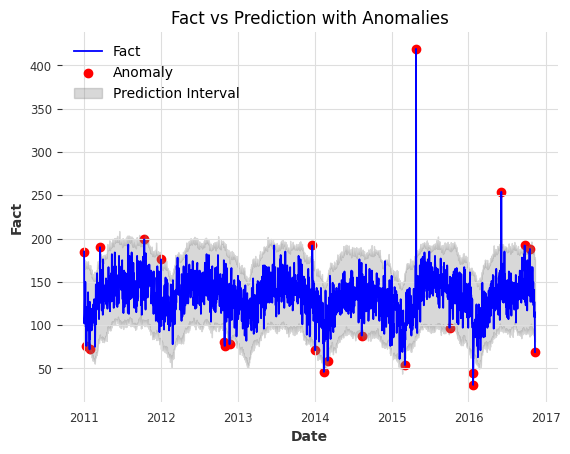

In [58]:
import matplotlib.pyplot as plt

# Assuming 'ds' is a datetime column, you might need to convert it to datetime
pred['ds'] = pd.to_datetime(pred['ds'])

# Plot 'fact' column
plt.plot(pred['ds'], pred['fact'], label='Fact', color='blue')

# Highlight anomalies with red markers
anomaly_indices = pred['anomaly'].abs() == 1
plt.scatter(pred['ds'][anomaly_indices], pred['fact'][anomaly_indices], color='red', label='Anomaly')

# Shade the region between 'yhat_lower' and 'yhat_upper'
plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='gray', alpha=0.3, label='Prediction Interval')

# Customize the plot
plt.title('Fact vs Prediction with Anomalies')
plt.xlabel('Date')
plt.ylabel('Fact')
plt.legend()
plt.show()
